# Test Factor Models VaR and ES
This notebook demonstrates how to use:
- A single-factor model Value-at-Risk (VaR) and Expected Shortfall (ES)
- A Fama-French 3-factor model for VaR and ES

It uses historical return data and factor models to estimate portfolio risk.

In [28]:
import data_download as dd
import factor_models as fm
import pandas as pd
import numpy as np
import plots
import backtesting as bt

##  Download data and form a portfolio

In [29]:
# Define tickers and shares
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "JPM",
    "UNH", "KO", "PEP", "BMW.DE", "NESN.SW",
    "NOVN.SW", "ASML.AS"
]

# Assign number of shares per asset
shares = pd.Series(10, index=tickers)

# Download adjusted prices
prices = dd.get_raw_prices(tickers, start="2010-01-01", end="2022-01-01")

# Compute daily value of each position
position_values = prices * shares

# Compute total portfolio value over time
portfolio_value_series = position_values.sum(axis=1)

# Compute asset weights (based on latest available prices)
latest_prices = prices.iloc[-1]
portfolio_value = (shares * latest_prices).sum()
weights = (shares * latest_prices) / portfolio_value

# Compute daily asset returns and portfolio returns
returns = prices.pct_change().dropna()
portfolio_returns = returns @ weights

# Combine historical values into one DataFrame
portfolio_df = position_values.copy()
portfolio_df["PORTFOLIO"] = portfolio_value_series

# Display results
portfolio_df.head()


,AAPL,ASML.AS,BMW.DE,GOOGL,JPM,KO,MSFT,NESN.SW,NOVN.SW,NVDA,PEP,UNH,PORTFOLIO
Date,,,,,,,,,,,,,
2010-01-04,64.318953,270.231400,158.758421,156.098042,288.291740,178.183079,232.114353,315.713997,236.474476,4.238837,391.336746,250.959530,2546.719573
2010-01-05,64.430151,270.732613,160.046349,155.410643,293.875904,176.027641,232.189426,308.278198,232.393551,4.300734,396.065369,250.561447,2544.312026
2010-01-06,63.405318,273.628826,162.523060,151.492939,295.490665,175.965195,230.764446,303.382835,232.827396,4.328244,392.103539,253.028870,2538.941334
2010-01-07,63.288112,268.616219,163.959560,147.966251,301.343975,175.527802,228.364601,299.912834,231.104870,4.243421,389.611282,262.739296,2536.678223
2010-01-08,63.708882,259.593678,161.755295,149.938803,300.603886,172.279053,229.939480,304.312363,231.104870,4.252591,388.333435,260.271912,2526.094246


In [30]:
print(weights)

AAPL       0.071517
ASML.AS    0.279871
BMW.DE     0.027791
GOOGL      0.059156
JPM        0.059068
KO         0.022036
MSFT       0.134001
NESN.SW    0.046579
NOVN.SW    0.026621
NVDA       0.012047
PEP        0.064818
UNH        0.196495
dtype: float64


In [31]:
portfolio_value

24370.10639190674

## Single-Factor VaR and ES

The Single-Factor model assumes that all asset returns are driven by a single common factor — typically the market index.  
This is also referred to as the **Sharpe Single-Index Model**, and is a special case of the delta-normal method.

Each asset’s return is modeled as:

$$
R_i = \alpha_i + \beta_i R_m + \varepsilon_i
$$

where:
- $R_m$ is the market return
- $\beta_i$ is the sensitivity of asset $i$ to the market
- $\varepsilon_i$ is the idiosyncratic (asset-specific) risk

The total variance of asset $i$ is:

$$
\sigma_i^2 = \beta_i^2 \sigma_m^2 + \sigma_{\varepsilon_i}^2
$$

The portfolio’s covariance matrix is approximated as:

$$
\Sigma = \beta \beta^T \cdot \sigma_m^2 + D
$$

where:
- $\beta$: vector of asset betas
- $\sigma_m^2$: variance of the market return
- $D$: diagonal matrix of idiosyncratic variances

Finally, the portfolio VaR at confidence level $\alpha$ is given by:

$$
\text{VaR}_{\alpha} = z_\alpha \cdot \sigma_p \cdot \text{PortfolioValue}
$$

and the Expected Shortfall (ES) is:

$$
\text{ES}_{\alpha} = \frac{\phi(z_\alpha)}{1 - \alpha} \cdot \sigma_p \cdot \text{PortfolioValue}
$$

where $z_\alpha$ is the quantile of the standard normal distribution and $\phi$ is the standard normal PDF.


In [34]:
# download SP prices
sp = dd.get_raw_prices(["^GSPC"], start="2010-01-01", end="2022-01-01")

# compute benchmark returns
benchmark = sp["^GSPC"].pct_change().dropna()

# align benchmark with asset returns
benchmark = benchmark.reindex(returns.index).ffill()

In [35]:
results_df, portfolio_volatility = fm.single_factor_var(
    returns=returns,
    benchmark=benchmark,
    weights=weights,
    portfolio_value=portfolio_value,
    confidence_level=0.99
)


In [36]:
results_df.head()   

,Returns,Benchmark,VaR,VaR Violation,VaR_monetary
Date,,,,,
2010-01-05,0.000620,0.003116,0.025638,False,624.805324
2010-01-06,0.000963,0.000546,0.025638,False,624.805324
2010-01-07,-0.000506,0.004001,0.025638,False,624.805324
2010-01-08,-0.009487,0.002882,0.025638,False,624.805324
2010-01-11,-0.012184,0.001747,0.025638,False,624.805324



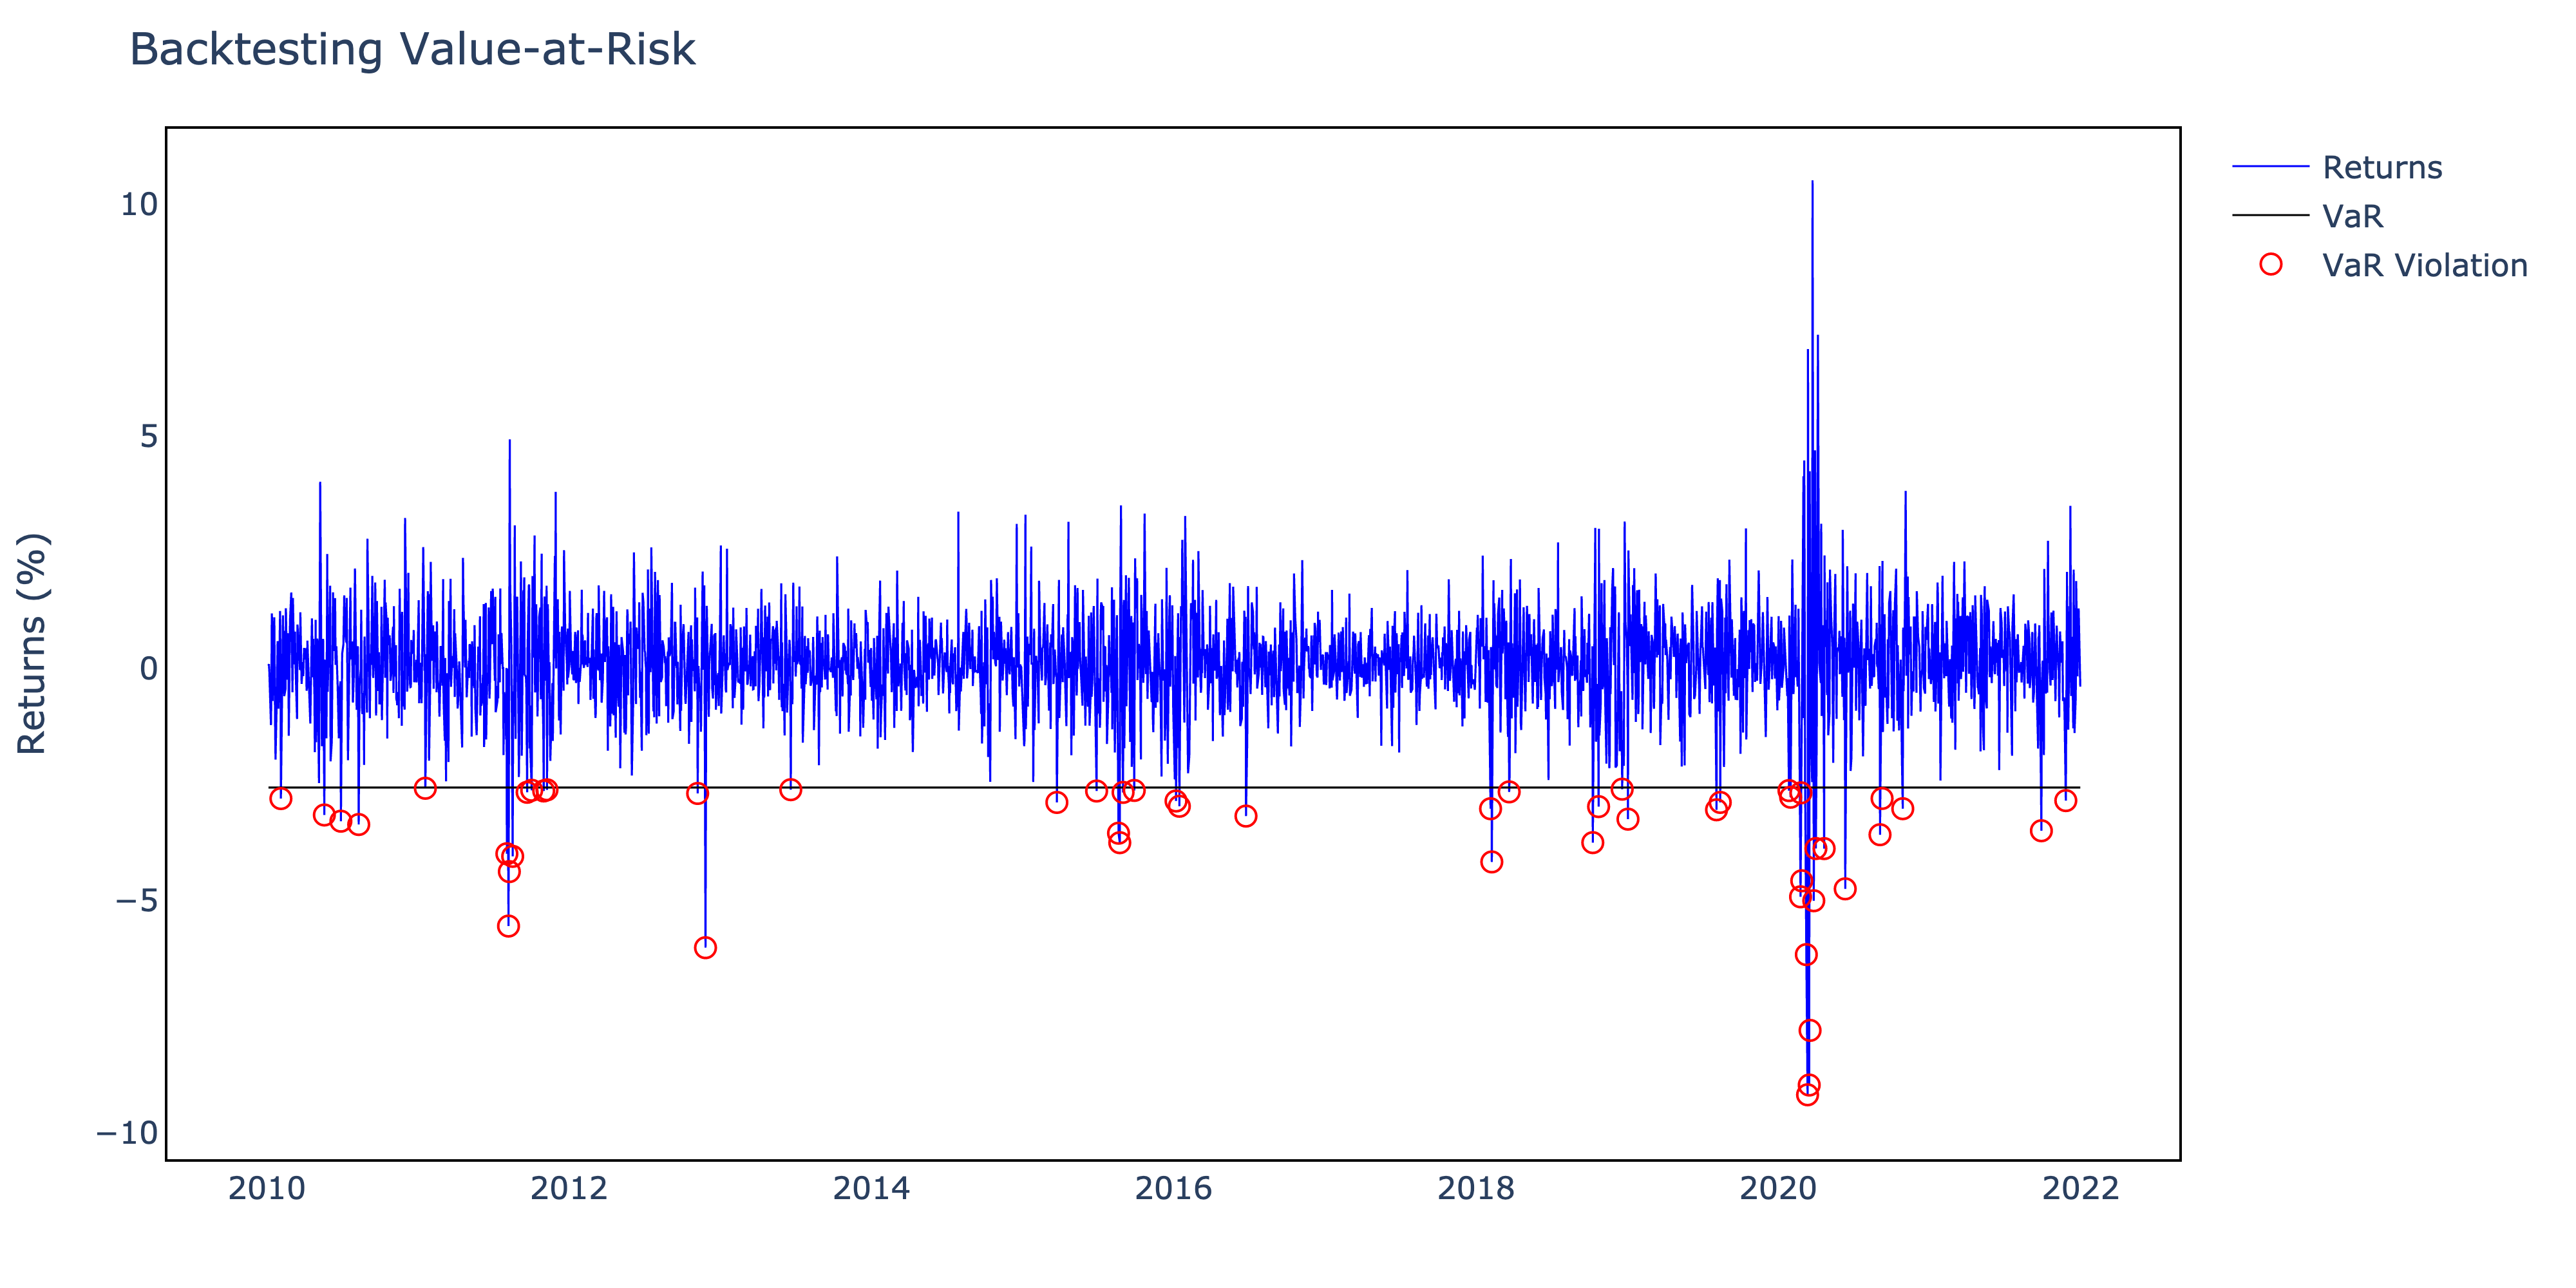

In [37]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df, interactive=False)

In [38]:
results_df = fm.factor_models_es(
    result_data= results_df,
    portfolio_volatility=portfolio_volatility,
    confidence_level = 0.99
)

In [39]:
results_df.head()

,Returns,Benchmark,VaR,VaR Violation,VaR_monetary,ES,ES_monetary
Date,,,,,,,
2010-01-05,0.000620,0.003116,0.025638,False,624.805324,0.029373,715.817291
2010-01-06,0.000963,0.000546,0.025638,False,624.805324,0.029373,715.817291
2010-01-07,-0.000506,0.004001,0.025638,False,624.805324,0.029373,715.817291
2010-01-08,-0.009487,0.002882,0.025638,False,624.805324,0.029373,715.817291
2010-01-11,-0.012184,0.001747,0.025638,False,624.805324,0.029373,715.817291



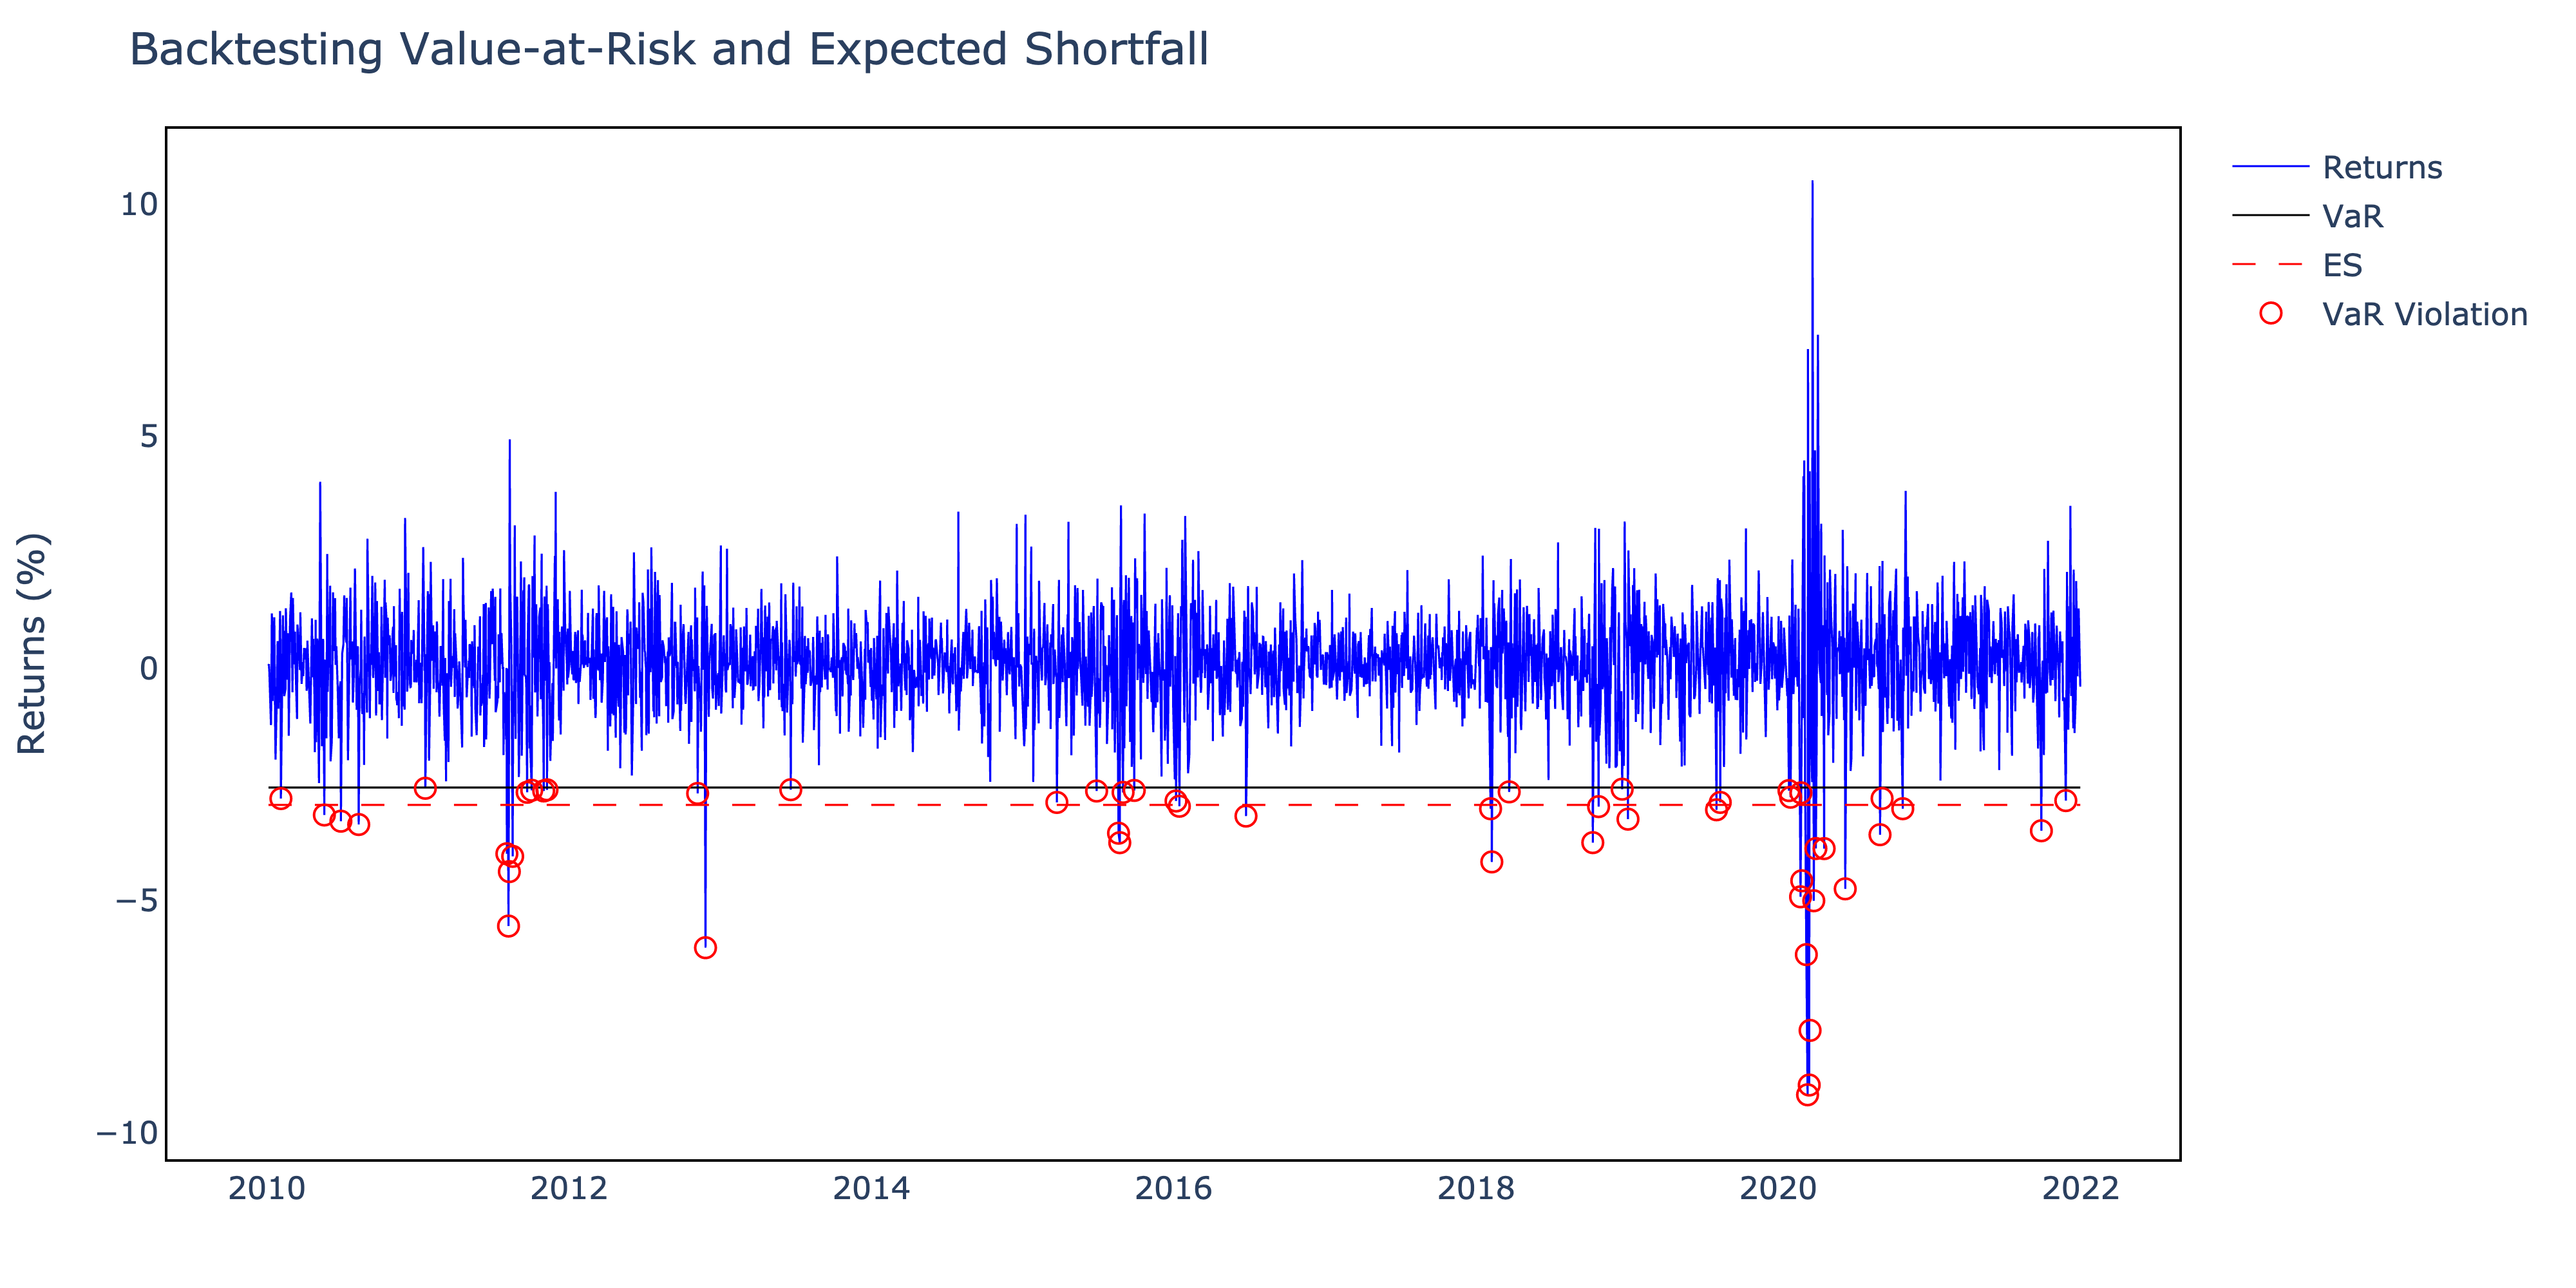

In [40]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df, interactive=False)

In [41]:
violations, violation_rate = bt.count_violations(results_df)

violations, violation_rate

(52, 0.016774193548387096)

## Fama-French 3-Factor VaR and ES

The Fama–French 3-factor model extends the CAPM by modeling asset returns using three sources of systematic risk:

- **Mkt_RF**: excess return of the market over the risk-free rate  
- **SMB** ("Small Minus Big"): return of small-cap stocks minus large-cap  
- **HML** ("High Minus Low"): return of high book-to-market stocks minus low  

Each asset’s excess return is regressed on these three factors to estimate its **exposures (betas)**. The model assumes:

$$
R_i - R_f = \alpha_i + \beta_{i1} \cdot \text{Mkt}_{RF} + \beta_{i2} \cdot \text{SMB} + \beta_{i3} \cdot \text{HML} + \varepsilon_i
$$

The estimated covariance matrix of asset returns is reconstructed as:

$$
\Sigma = B \cdot \Sigma_f \cdot B^T + D
$$

Where:
- $B$: matrix of asset betas  
- $\Sigma_f$: covariance matrix of factor returns  
- $D$: diagonal matrix of idiosyncratic variances  

The next code block performs the following steps:

1. Downloads the FF3 daily factor data from Ken French's database.
2. Computes **excess returns** for each asset over the risk-free rate.
3. Regresses each asset’s excess return on the three factors to obtain:
   - **Beta coefficients** (exposures to Mkt_RF, SMB, HML)
   - **Idiosyncratic variance** (residual risk)
4. Builds the **full covariance matrix** of asset returns using the factor structure.
5. Computes **portfolio volatility** using the covariance matrix and current weights.
6. Calculates:
   - **Value-at-Risk (VaR)** at the given confidence level
   - **Conditional VaR (CVaR)**, i.e. expected loss beyond the VaR threshold

The printed outputs show all key components estimated during this process.

In [42]:
# # Download FF3 daily factors and restrict to portfolio date range
# ff_factors = fm.load_ff3_factors(start=returns.index[0], end=returns.index[-1])

# # Check first few rows
# ff_factors.head()

In [43]:
new_df, portfolio_volatility_new = fm.fama_french_var(
    returns=returns, 
    weights=weights,
    portfolio_value=portfolio_value,
    confidence_level=0.99
)

new_df.head()

,Returns,Factor_Mkt_RF,Factor_SMB,Factor_HML,VaR,VaR Violation,VaR_monetary
Date,,,,,,,
2010-01-05,0.000620,0.0031,-0.0064,0.0124,0.025394,False,618.848338
2010-01-06,0.000963,0.0013,-0.0022,0.0057,0.025394,False,618.848338
2010-01-07,-0.000506,0.0040,0.0009,0.0098,0.025394,False,618.848338
2010-01-08,-0.009487,0.0033,0.0037,0.0001,0.025394,False,618.848338
2010-01-11,-0.012184,0.0013,-0.0013,-0.0025,0.025394,False,618.848338


In [44]:
results_df_new = fm.factor_models_es(
    result_data= new_df,
    portfolio_volatility=portfolio_volatility_new,
    confidence_level = 0.99
)

results_df_new.head()   

,Returns,Factor_Mkt_RF,Factor_SMB,Factor_HML,VaR,VaR Violation,VaR_monetary,ES,ES_monetary
Date,,,,,,,,,
2010-01-05,0.000620,0.0031,-0.0064,0.0124,0.025394,False,618.848338,0.029093,708.992584
2010-01-06,0.000963,0.0013,-0.0022,0.0057,0.025394,False,618.848338,0.029093,708.992584
2010-01-07,-0.000506,0.0040,0.0009,0.0098,0.025394,False,618.848338,0.029093,708.992584
2010-01-08,-0.009487,0.0033,0.0037,0.0001,0.025394,False,618.848338,0.029093,708.992584
2010-01-11,-0.012184,0.0013,-0.0013,-0.0025,0.025394,False,618.848338,0.029093,708.992584



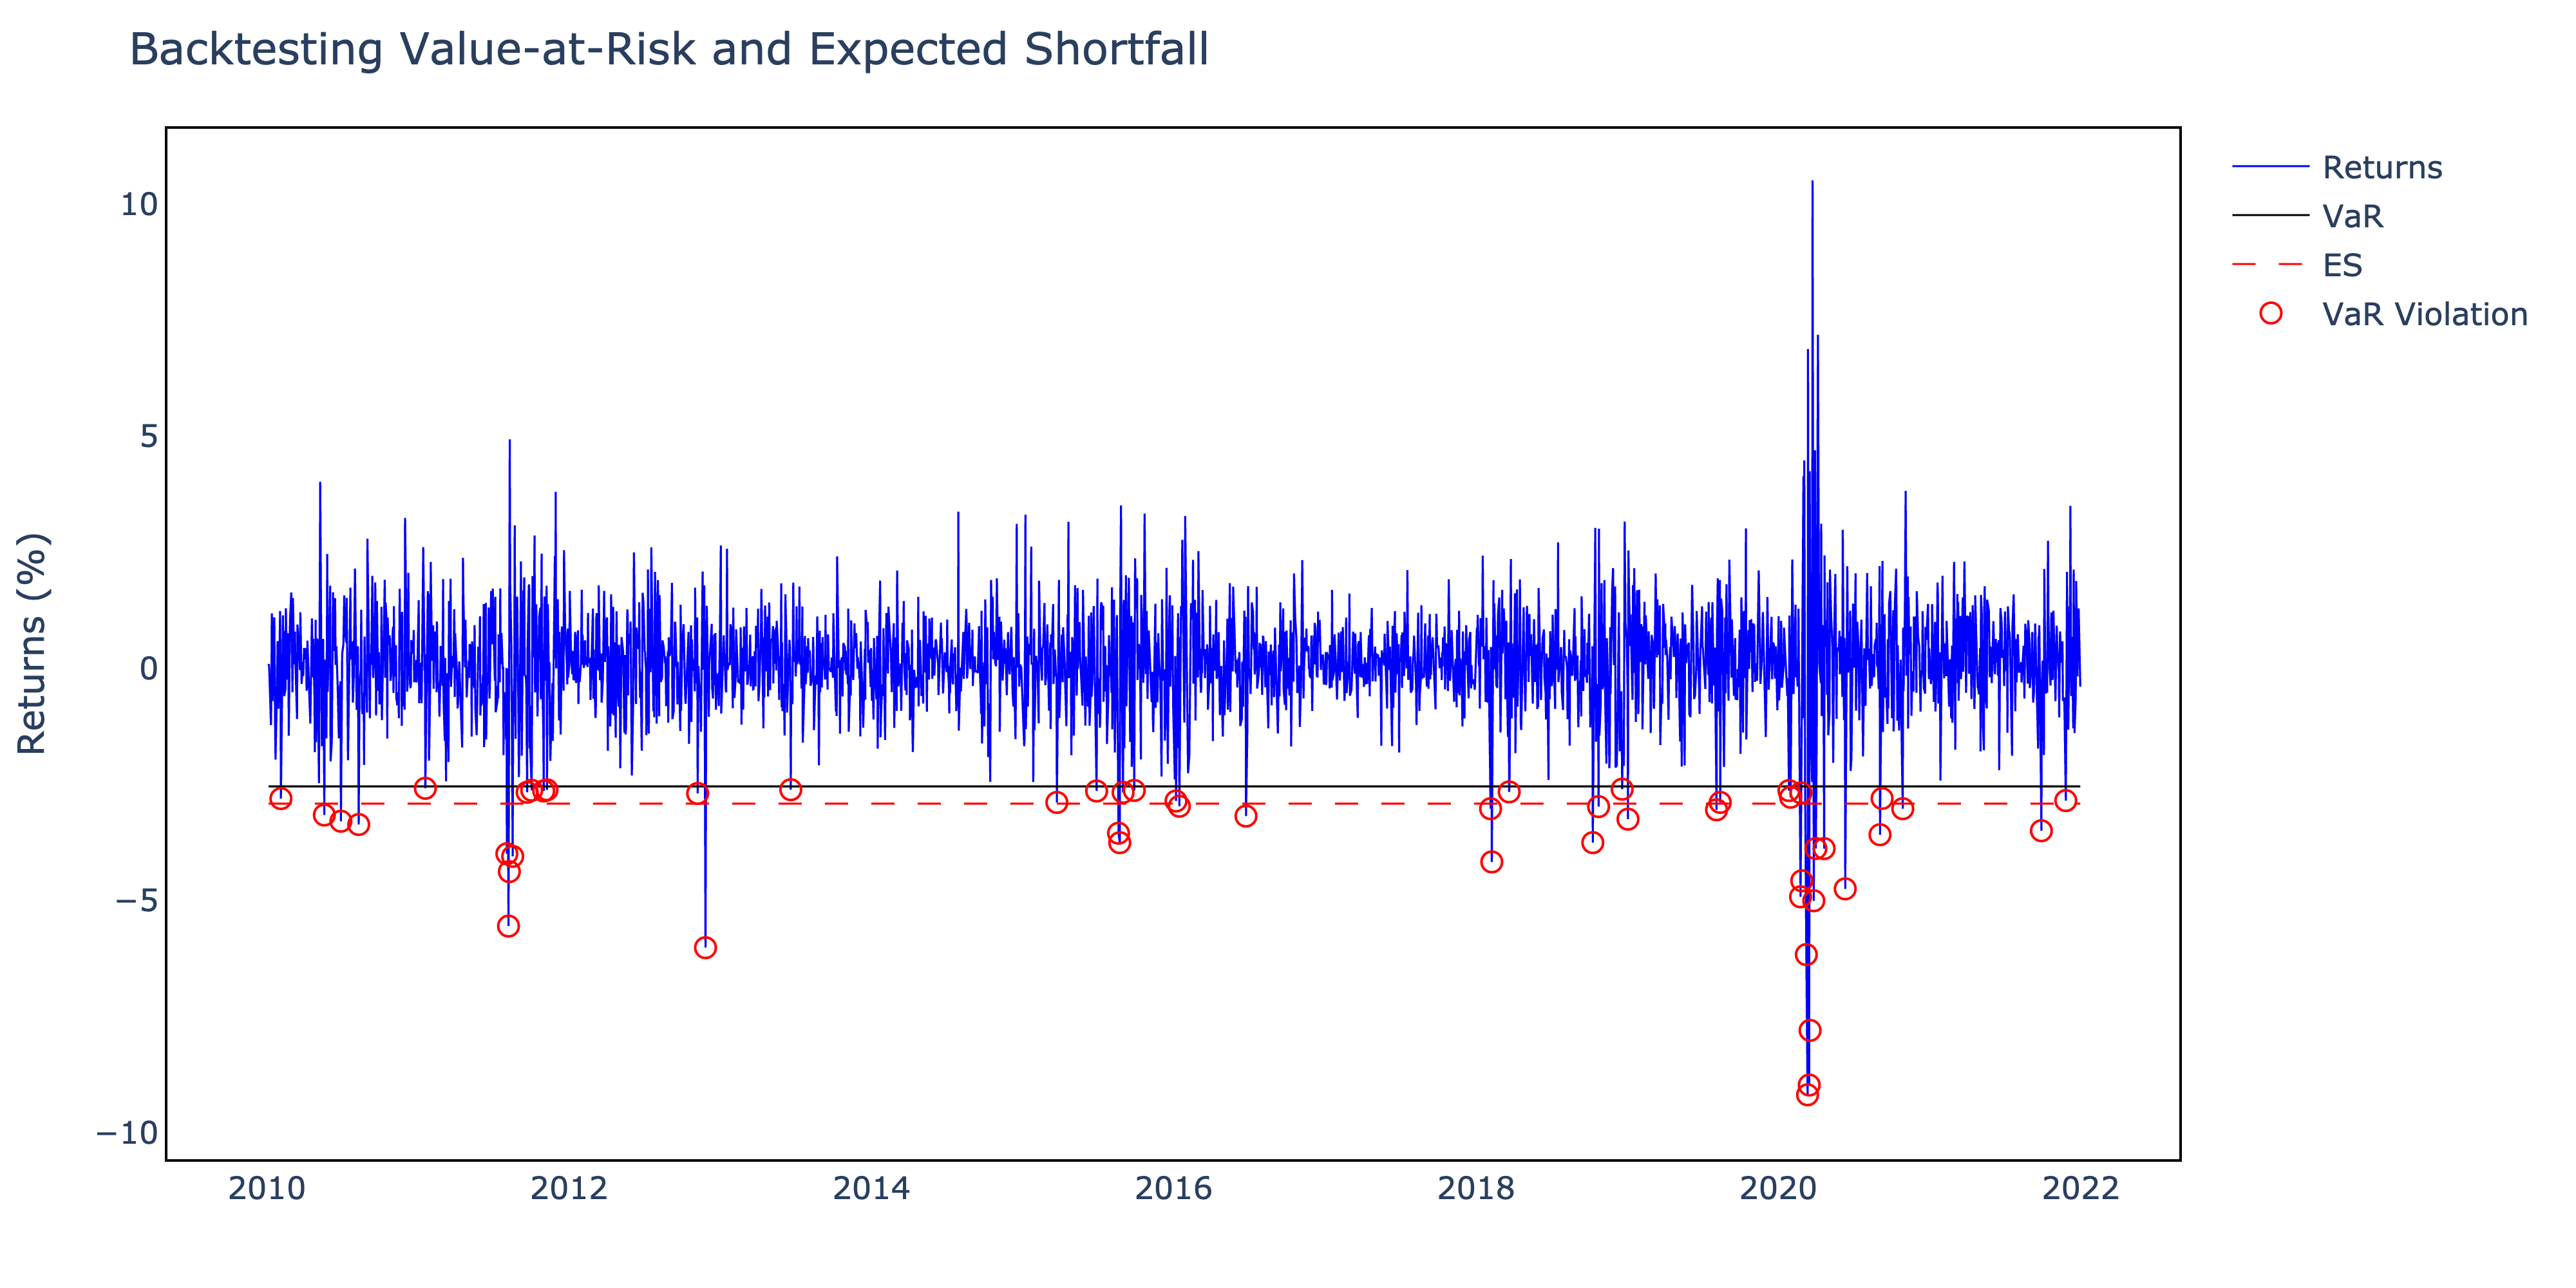

In [45]:
# Plot interactive VaR
fig_var = plots.plot_backtest(results_df_new, interactive=False)

In [46]:
violations_new, violation_rate_new = bt.count_violations(results_df_new)

violations_new, violation_rate_new

(52, 0.016774193548387096)